# Analyse Expeditions et stocks

###  Importation des bibliothèques nécessaires

In [31]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [32]:
# Configuration pour l'affichage des graphiques en français
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'DejaVu Sans'

## Chargement des données

In [33]:
# Chargement des données
stocks_df = pd.read_csv('../base/stocksV2.csv', sep=';')
expeditions_df = pd.read_csv('../base/expeditionsV2.csv', sep=';')

# Conversion des dates
stocks_df['date'] = pd.to_datetime(stocks_df['date'], format='%d/%m/%Y')
expeditions_df['date_expedition'] = pd.to_datetime(expeditions_df['date_expedition'])
expeditions_df['date_livraison'] = pd.to_datetime(expeditions_df['date_livraison'])

# Vérification des données manquantes
print("Valeurs manquantes dans les stocks:", stocks_df.isnull().sum().sum())
print("Valeurs manquantes dans les expéditions:", expeditions_df.isnull().sum().sum())

# Création de variables temporelles utiles
stocks_df['mois'] = stocks_df['date'].dt.month
stocks_df['jour_semaine'] = stocks_df['date'].dt.dayofweek
stocks_df['trimestre'] = stocks_df['date'].dt.quarter

expeditions_df['mois_expedition'] = expeditions_df['date_expedition'].dt.month
expeditions_df['jour_semaine_expedition'] = expeditions_df['date_expedition'].dt.dayofweek
expeditions_df['trimestre'] = expeditions_df['date_expedition'].dt.quarter

# Calcul du délai réel entre expédition et livraison
expeditions_df['delai_reel'] = (expeditions_df['date_livraison'] - expeditions_df['date_expedition']).dt.days
expeditions_df['ecart_delai'] = expeditions_df['delai_reel'] - expeditions_df['délai_livraison']

# Calcul du coût par unité expédiée
expeditions_df['cout_par_unite'] = expeditions_df['coût_transport'] / expeditions_df['quantité']

Valeurs manquantes dans les stocks: 0
Valeurs manquantes dans les expéditions: 0


## Analyse 

### Analyse des Niveaux de Stock

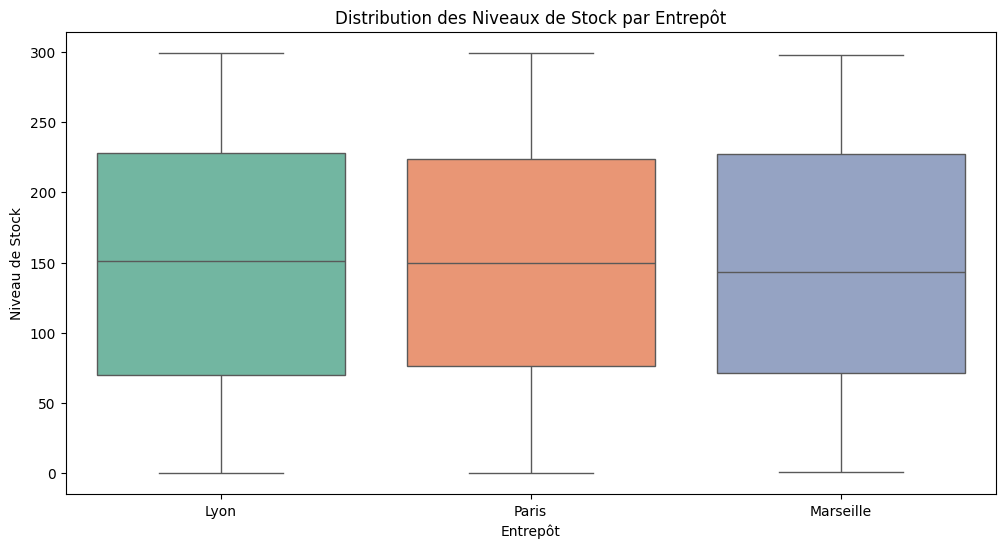

In [34]:
# Analyse des niveaux de stock par entrepôt
plt.figure(figsize=(12, 6))
sns.boxplot(x='entrepot', y='niveau_stock', data=stocks_df,hue='entrepot', palette='Set2')
plt.title('Distribution des Niveaux de Stock par Entrepôt')
plt.xlabel('Entrepôt')
plt.ylabel('Niveau de Stock')
plt.show()



C:\Users\Djo\AppData\Local\Temp\ipykernel_24956\901976634.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_mensuel = stocks_df.groupby(['entrepot', pd.Grouper(key='date', freq='M')])['niveau_stock'].mean().reset_index()


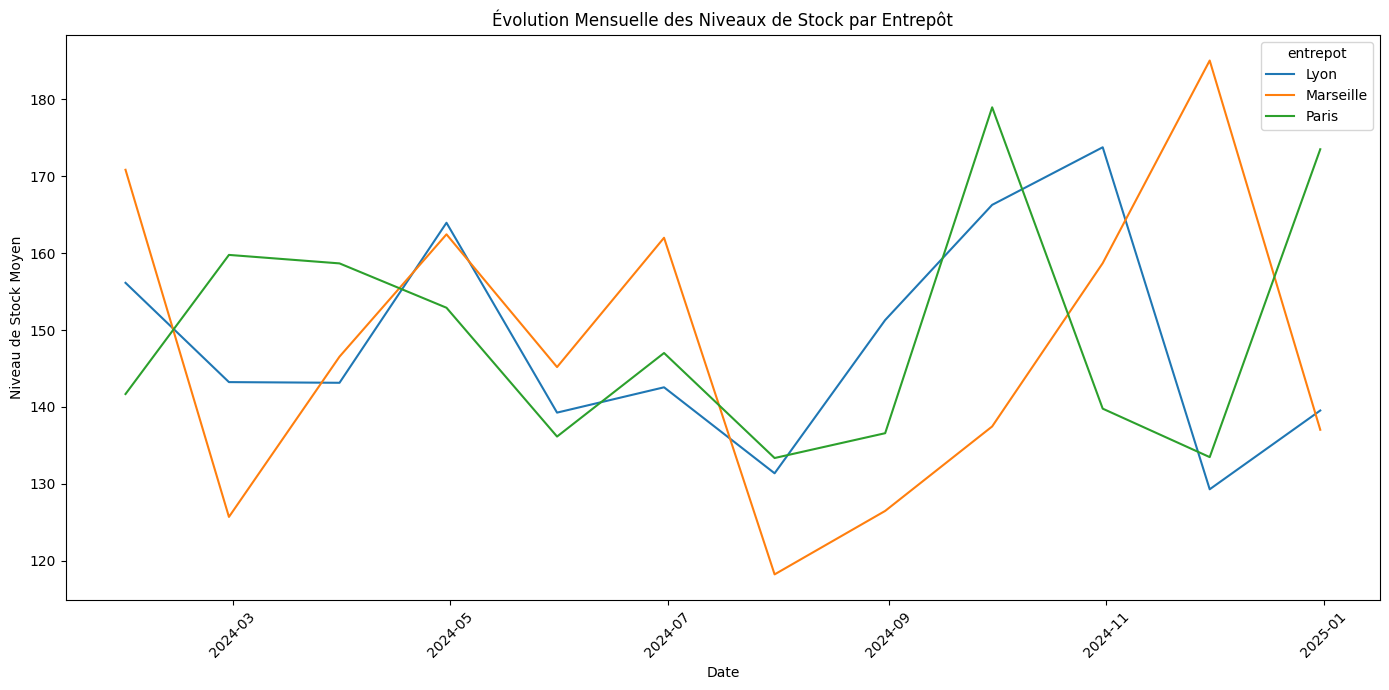

In [35]:
# Évolution des niveaux de stock moyens au fil du temps
stock_mensuel = stocks_df.groupby(['entrepot', pd.Grouper(key='date', freq='M')])['niveau_stock'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='niveau_stock', hue='entrepot', data=stock_mensuel)
plt.title('Évolution Mensuelle des Niveaux de Stock par Entrepôt')
plt.xlabel('Date')
plt.ylabel('Niveau de Stock Moyen')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [36]:
# Identification des produits avec des niveaux de stock critiques
stock_actuel = stocks_df.sort_values('date').drop_duplicates(subset=['id_produit', 'entrepot'], keep='last')
stock_critique = stock_actuel[stock_actuel['niveau_stock'] < 20].sort_values('niveau_stock')

print("Produits en situation de stock critique (<20 unités):")
print(stock_critique[['id_produit', 'entrepot', 'niveau_stock']].head(10))


Produits en situation de stock critique (<20 unités):
     id_produit   entrepot  niveau_stock
642      P00377       Lyon             0
1286     P00758      Paris             0
1152     P00678       Lyon             0
543      P00318       Lyon             0
1150     P00676       Lyon             0
957      P00567      Paris             0
1185     P00698      Paris             0
1357     P00797  Marseille             1
249      P00148       Lyon             1
574      P00338      Paris             1


## Analyse des Expéditions

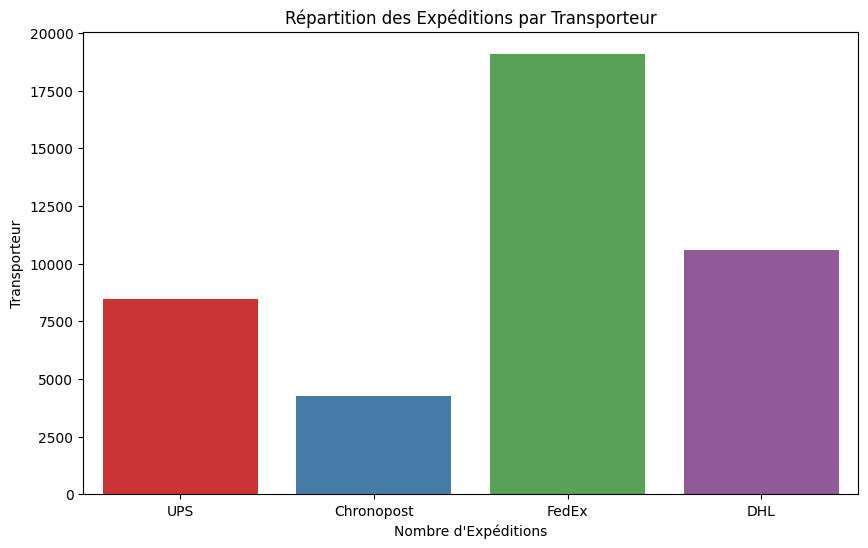

In [57]:
# Distribution des expéditions par transporteur
plt.figure(figsize=(10, 6))
sns.countplot(x='transporteur', data=expeditions_df,hue='transporteur', palette='Set1')
plt.title('Répartition des Expéditions par Transporteur')
plt.xlabel('Nombre d\'Expéditions')
plt.ylabel('Transporteur')
plt.show()


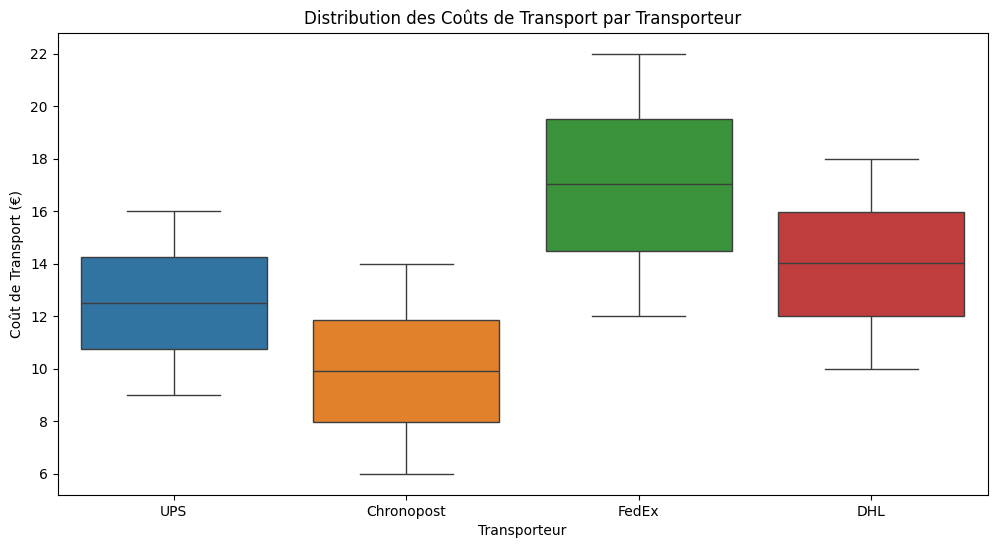

In [38]:

# Analyse des coûts de transport par transporteur
plt.figure(figsize=(12, 6))
sns.boxplot(x='transporteur', y='coût_transport', data=expeditions_df,hue='transporteur')
plt.title('Distribution des Coûts de Transport par Transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Coût de Transport (€)')
plt.show()


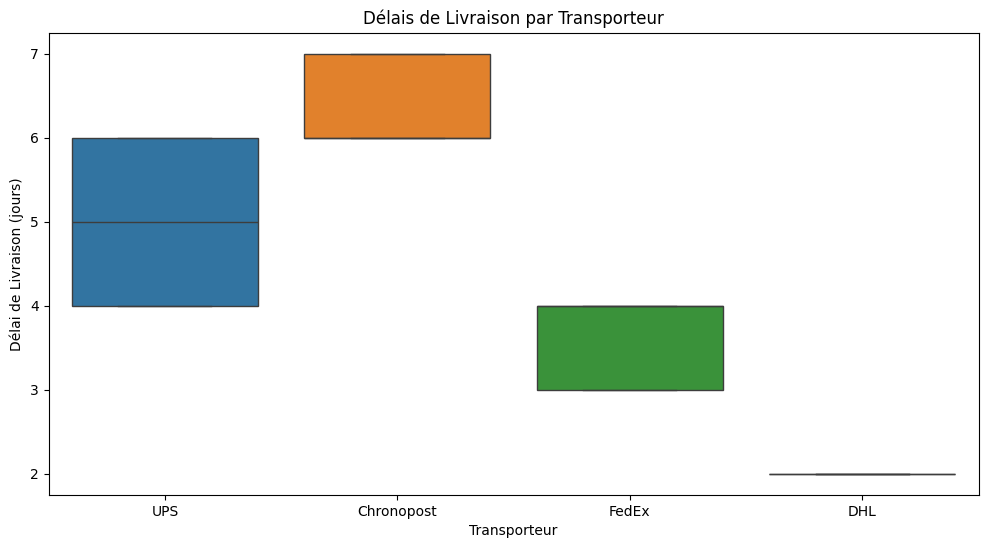

In [39]:

# Analyse des délais de livraison par transporteur
plt.figure(figsize=(12, 6))
sns.boxplot(x='transporteur', y='délai_livraison', data=expeditions_df,hue='transporteur')
plt.title('Délais de Livraison par Transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Délai de Livraison (jours)')
plt.show()


C:\Users\Djo\AppData\Local\Temp\ipykernel_24956\3956754712.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  expeditions_mensuelles = expeditions_df.groupby([pd.Grouper(key='date_expedition', freq='M')])['quantité'].sum().reset_index()


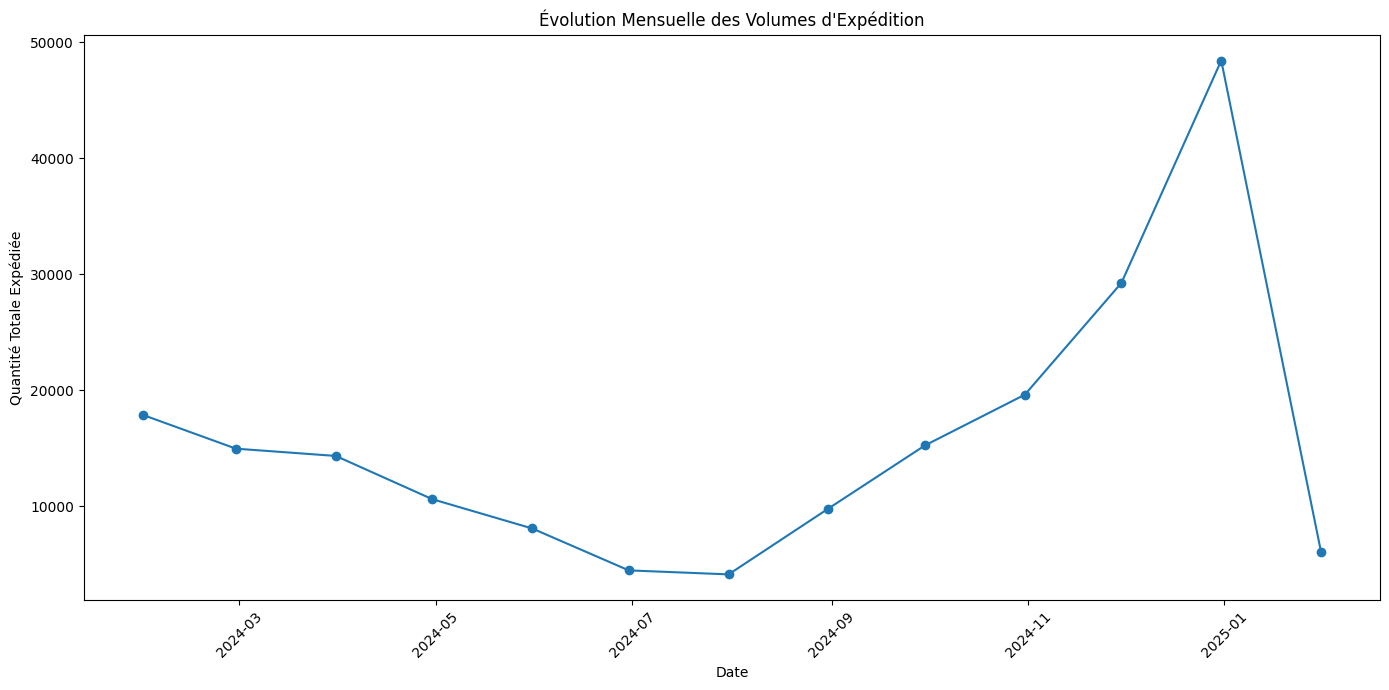

In [40]:

# Évolution des volumes d'expédition dans le temps
expeditions_mensuelles = expeditions_df.groupby([pd.Grouper(key='date_expedition', freq='M')])['quantité'].sum().reset_index()
plt.figure(figsize=(14, 7))
plt.plot(expeditions_mensuelles['date_expedition'], expeditions_mensuelles['quantité'], marker='o')
plt.title('Évolution Mensuelle des Volumes d\'Expédition')
plt.xlabel('Date')
plt.ylabel('Quantité Totale Expédiée')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Analyse du Rapport entre Stocks et Expéditions

In [41]:
# Création d'un dataframe des expéditions quotidiennes
expeditions_daily = expeditions_df.groupby(['date_expedition', 'id_produit', 'entrepôt'])['quantité'].sum().reset_index()
expeditions_daily = expeditions_daily.rename(columns={'date_expedition': 'date', 'entrepôt': 'entrepot'})

# Jointure avec les données de stock
stock_exp_df = pd.merge(stocks_df, expeditions_daily, on=['date', 'id_produit', 'entrepot'], how='left')
#stock_exp_df['quantité'] = stock_exp_df['quantité'].fillna(0)


In [42]:

# Calcul du ratio d'expédition par rapport au stock
stock_exp_df['ratio_exp_stock'] = stock_exp_df['quantité'] / stock_exp_df['niveau_stock']
#stock_exp_df['ratio_exp_stock'] = stock_exp_df['ratio_exp_stock'].replace([np.inf, -np.inf], np.nan).fillna(0)
stock_exp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1706 entries, 0 to 1705
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1706 non-null   datetime64[ns]
 1   id_produit       1706 non-null   object        
 2   entrepot         1706 non-null   object        
 3   niveau_stock     1706 non-null   int64         
 4   mois             1706 non-null   int32         
 5   jour_semaine     1706 non-null   int32         
 6   trimestre        1706 non-null   int32         
 7   quantité         55 non-null     float64       
 8   ratio_exp_stock  55 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1), object(2)
memory usage: 100.1+ KB


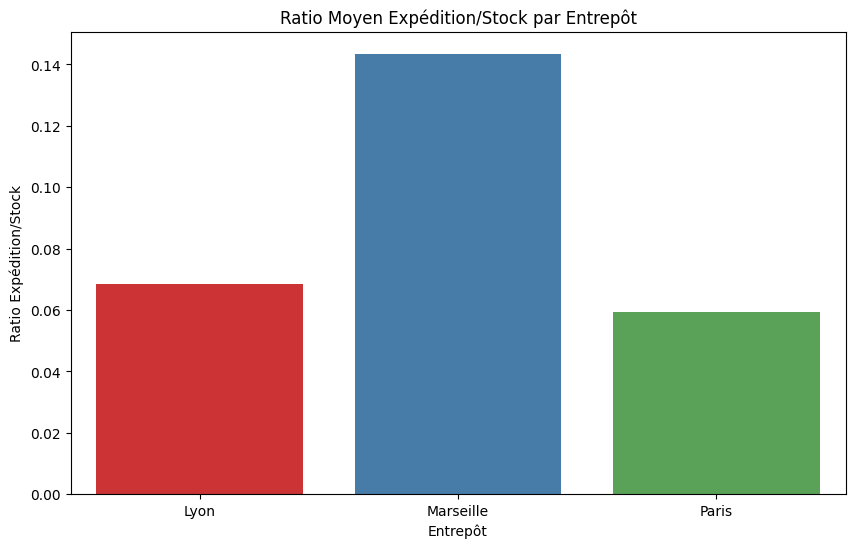

In [43]:

# Analyse du ratio moyen par entrepôt
ratio_entrepot = stock_exp_df.groupby('entrepot')['ratio_exp_stock'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='entrepot', y='ratio_exp_stock', data=ratio_entrepot,hue='entrepot', palette='Set1')
plt.title('Ratio Moyen Expédition/Stock par Entrepôt')
plt.xlabel('Entrepôt')
plt.ylabel('Ratio Expédition/Stock')
plt.show()


In [44]:

# Identification des produits à faible rotation (ratio < 0.05)
rotation_produits = stock_exp_df.groupby('id_produit')['ratio_exp_stock'].mean().reset_index()
low_rotation = rotation_produits[rotation_produits['ratio_exp_stock'] < 0.05].sort_values('ratio_exp_stock')
print(f"Produits à faible rotation (ratio < 0.05): {len(low_rotation)}")
print(low_rotation.head(10))


Produits à faible rotation (ratio < 0.05): 34
    id_produit  ratio_exp_stock
224     P00225         0.003623
571     P00572         0.003745
450     P00451         0.004049
411     P00412         0.004717
252     P00253         0.004739
378     P00379         0.004926
737     P00738         0.006289
296     P00297         0.007143
385     P00386         0.007246
466     P00467         0.007874


In [45]:

# Identification des produits à forte rotation (ratio > 0.5)
high_rotation = rotation_produits[rotation_produits['ratio_exp_stock'] > 0.5].sort_values('ratio_exp_stock', ascending=False)
print(f"Produits à forte rotation (ratio > 0.5): {len(high_rotation)}")
print(high_rotation.head(10))


Produits à forte rotation (ratio > 0.5): 1
    id_produit  ratio_exp_stock
520     P00521              1.0


## Analyse des Inefficacités de Coûts de Transport

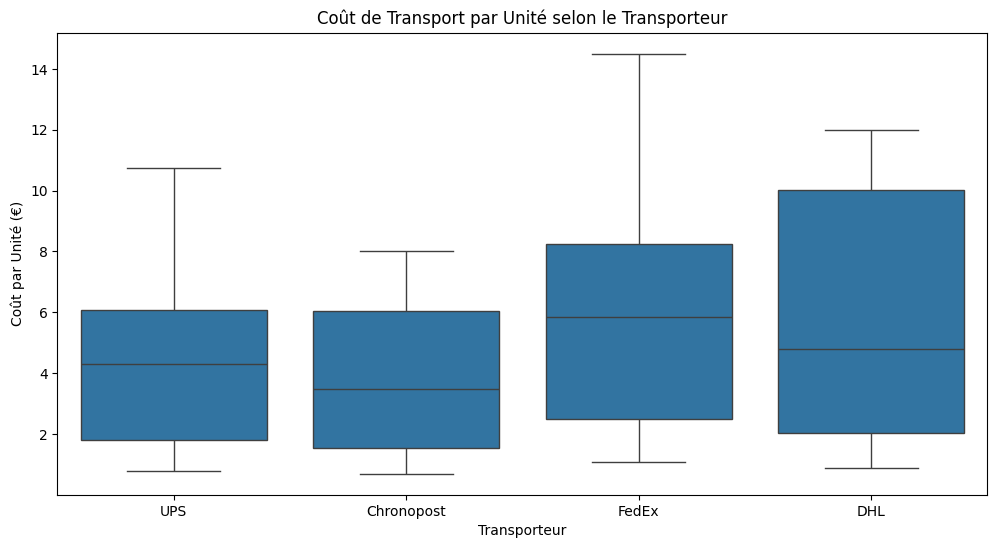

In [46]:
# Analyse du coût par unité selon le transporteur
plt.figure(figsize=(12, 6))
sns.boxplot(x='transporteur', y='cout_par_unite', data=expeditions_df)
plt.title('Coût de Transport par Unité selon le Transporteur')
plt.xlabel('Transporteur')
plt.ylabel('Coût par Unité (€)')
plt.show()


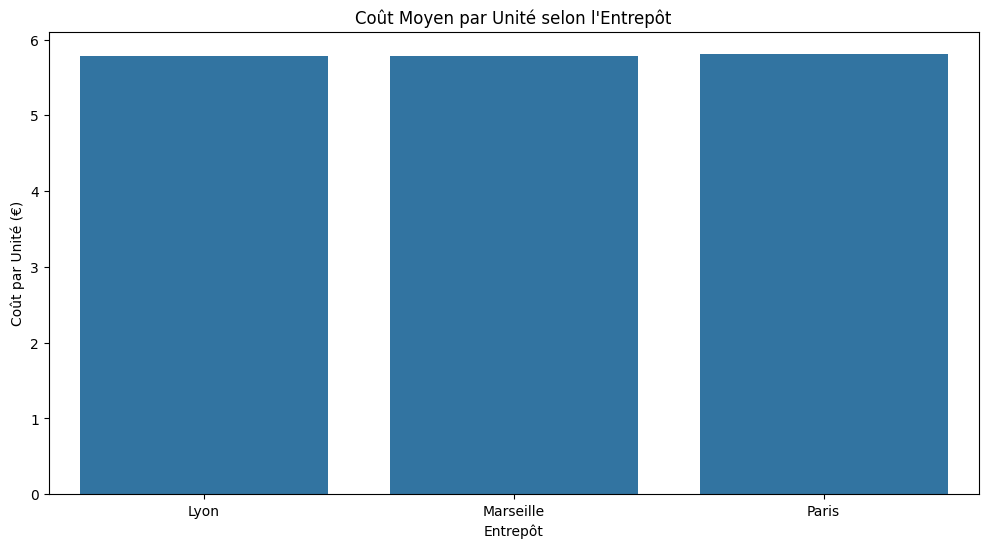

In [47]:

# Analyse des coûts par entrepôt
cout_entrepot = expeditions_df.groupby('entrepôt').agg({
    'coût_transport': 'mean',
    'cout_par_unite': 'mean',
    'délai_livraison': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='entrepôt', y='cout_par_unite', data=cout_entrepot)
plt.title('Coût Moyen par Unité selon l\'Entrepôt')
plt.xlabel('Entrepôt')
plt.ylabel('Coût par Unité (€)')
plt.show()


In [48]:

# Analyse des combinaisons entrepôt/transporteur
combo_efficacite = expeditions_df.groupby(['entrepôt', 'transporteur']).agg({
    'cout_par_unite': 'mean',
    'délai_livraison': 'mean',
    'quantité': 'sum'
}).reset_index()


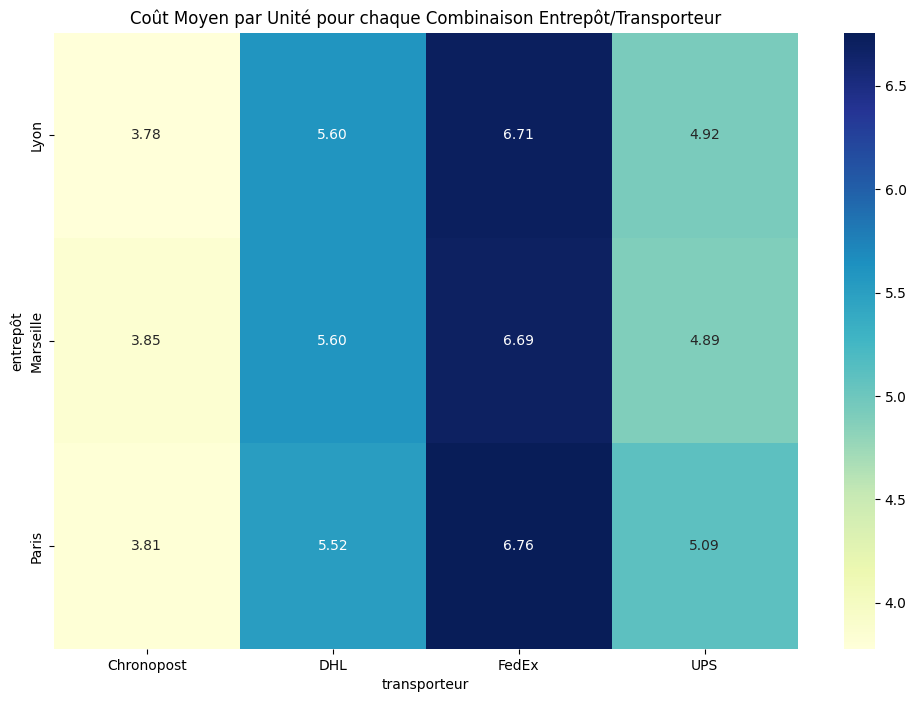

In [50]:

#  Visualisation sous forme de heatmap
pivot_cout = combo_efficacite.pivot(index='entrepôt', columns='transporteur', values='cout_par_unite')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_cout, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Coût Moyen par Unité pour chaque Combinaison Entrepôt/Transporteur')
plt.show()

In [51]:

# Identification des combinaisons optimales
transporteur_optimal = combo_efficacite.loc[combo_efficacite.groupby('entrepôt')['cout_par_unite'].idxmin()]
print("Transporteur le plus économique par entrepôt:")
print(transporteur_optimal[['entrepôt', 'transporteur', 'cout_par_unite', 'délai_livraison']])


Transporteur le plus économique par entrepôt:
    entrepôt transporteur  cout_par_unite  délai_livraison
0       Lyon   Chronopost        3.777328         6.500000
4  Marseille   Chronopost        3.850119         6.489796
8      Paris   Chronopost        3.809190         6.502460


## Analyse des Ecarts de Délais de Livraison 

In [52]:
expeditions_df['ecart_delai'].describe()

count    42404.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: ecart_delai, dtype: float64

Écarts de délai par transporteur:
  transporteur  mean  std
0   Chronopost   0.0  0.0
1          DHL   0.0  0.0
2        FedEx   0.0  0.0
3          UPS   0.0  0.0


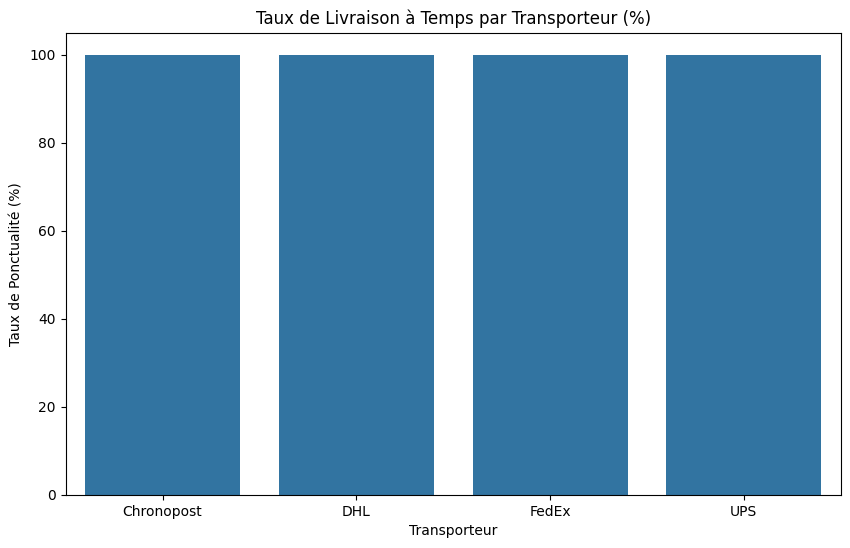

In [53]:

# Analyse des écarts par transporteur
ecart_transporteur = expeditions_df.groupby('transporteur')['ecart_delai'].agg(['mean', 'std']).reset_index()
print("Écarts de délai par transporteur:")
print(ecart_transporteur)

# Taux de livraison à temps par transporteur
expeditions_df['livraison_a_temps'] = expeditions_df['ecart_delai'] <= 0
taux_ponctualite = expeditions_df.groupby('transporteur')['livraison_a_temps'].mean().reset_index()
taux_ponctualite['taux_ponctualite'] = taux_ponctualite['livraison_a_temps'] * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='transporteur', y='taux_ponctualite', data=taux_ponctualite)
plt.title('Taux de Livraison à Temps par Transporteur (%)')
plt.xlabel('Transporteur')
plt.ylabel('Taux de Ponctualité (%)')
plt.show()
